## Figure 2 - InSAR observations at Shinmoedake from ALOS-1

In [1]:
%matplotlib inline
import os
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt, ticker, dates as mdates
from mintpy.defaults.plot import *
from mintpy.objects import sensor
from mintpy.utils import utils as ut, ptime, plot as pp, readfile
from mintpy import view, asc_desc2horz_vert

work_dir = os.path.expanduser('~/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS1')
os.chdir(work_dir)
print('Go to directory', work_dir)

# Common settings
event_dates = ptime.date_list2vector(['20080822', '20100710'])[0]

Go to directory /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS1


### Read displacement time-series

In [2]:
data_dirs = [os.path.expanduser('~/insarlab/Kirishima/ShinmoeAlosAT424/mintpy'),
             os.path.expanduser('~/insarlab/Kirishima/ShinmoeAlosDT73/mintpy')]
lalo_list = [[31.9122, 130.8842],
             [31.9125, 130.8856]]

## Common setting:
# These two dataset has the same spatial coverage and resolution
atr = readfile.read_attribute(os.path.join(data_dirs[0], 'velocity.h5'))
phase2range = -1 * float(atr['WAVELENGTH']) / (4*np.pi)

## read data
unw_file_list = []
dis_ts_list = []
dates_list = []
idx_ex_list = []
idx_kp_list = []

for data_dir, lalo in zip(data_dirs, lalo_list):
    lat, lon = lalo
    proj_name = sensor.project_name2sensor_name(data_dir)[1]
    print('-'*20)
    print('project: {}'.format(proj_name))

    ts_file = os.path.join(data_dir, 'timeseries_ERA5_ramp_demErr.h5')
    dates, dis_ts = ut.read_timeseries_lalo(lat, lon, ts_file, unit='cm', print_msg=False)

    vel_file = os.path.join(data_dir, 'velocity.h5')
    date12 = readfile.read_attribute(vel_file)['DATE12']
    unw_file = os.path.join(data_dir, '{}.unw'.format(date12))

    y, x = ut.coordinate(atr).geo2radar(lat, lon)[0:2]
    vel = readfile.read(vel_file)[0] * 100.
    dis = readfile.read(unw_file)[0] * 100. * phase2range
    print('date12: {}'.format(date12))
    print('velocity: {:.1f} cm/yr'.format(vel[y, x]))
    print('displacement between phreatic eruptions: {:.1f} cm'.format(dis[y, x]))
    print('displacement range for the whole time: [{:.1f}, {:.1f}] cm'.format(np.min(dis_ts), np.max(dis_ts)))

    ex_date_txt = os.path.join(data_dir, 'exclude_date.txt')
    ex_dates = ptime.date_list2vector(ptime.read_date_list(ex_date_txt))[0]
    idx_ex = [dates.tolist().index(di) for di in dates if di in ex_dates]
    idx_kp = [dates.tolist().index(di) for di in dates if di not in ex_dates]

    # save
    unw_file_list.append(unw_file)
    dis_ts_list.append(dis_ts)
    dates_list.append(dates)
    idx_ex_list.append(idx_ex)
    idx_kp_list.append(idx_kp)

--------------------
project: ShinmoeAlosAT424
date12: 20080929_20100520
velocity: -3.0 cm/yr
displacement between phreatic eruptions: -5.0 cm
displacement range for the whole time: [-4.7, 3.1] cm
--------------------
project: ShinmoeAlosDT73
date12: 20081012_20100302
velocity: -3.8 cm/yr
displacement between phreatic eruptions: -5.7 cm
displacement range for the whole time: [-4.3, 1.9] cm


### Plot displacement time-series

save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS1/dis_ts.png


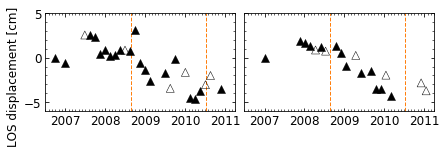

In [9]:
## Figure 2 (a-b)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 1.5], sharex=True, sharey=True)
for i in range(2):
    ax = axs[i]
    dis_ts = dis_ts_list[i]
    dates = dates_list[i]
    idx_ex = idx_ex_list[i]
    idx_kp = idx_kp_list[i]

    ax.scatter(dates[idx_ex], dis_ts[idx_ex], marker='^', edgecolor='k', facecolors='none', s=4**3, linewidths=0.5)
    ax.scatter(dates[idx_kp], dis_ts[idx_kp], marker='^', edgecolor='k', facecolors='k', s=4**3, linewidths=0.5)

    # plot event dates in dashed lines
    for e_date in event_dates:
        ax.axvline(x=e_date, c=pp.mplColors[1], linestyle='--', linewidth=1, zorder=0, clip_on=False)

# axes format
for ax in axs:
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    pp.auto_adjust_xaxis_date(ax, dates_list[0])
    ax.set_xlim(dt(2006, 7, 1), dt(2011, 4, 1))
    ax.set_ylim([-6, 5])
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
axs[0].set_ylabel('LOS displacement [cm]', fontsize=font_size, y=0.35)
fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# output
out_file = os.path.abspath('dis_ts.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

### Plot asc / desc displacement map

save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS1/dis_map_asc_desc.png


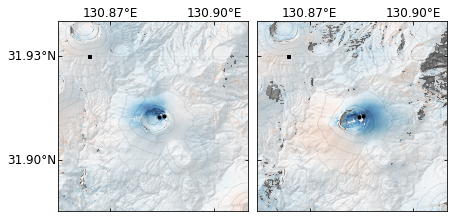

In [12]:
## Figure 2. (a-b) Map view of deformation from InSAR
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 3], sharex=True)

# view.py options
dem_file  = os.path.expanduser('~/insarlab/Kirishima/DEM/Shinmoe10m.dem.wgs84')
opt = ' --sub-lat 31.885 31.94 --sub-lon 130.855 130.91 '
opt += '--dem {} --contour-step 100 --contour-smooth 0.0 '.format(dem_file)
opt += ' -c RdBu_r -v -5 5 -u cm '
opt += ' --notitle --fontsize 12 --ref-size 3 --lalo-step 0.03 --nocbar --noscalebar --alpha 0.7 '
opt += ' --noverbose '

lalo_locs = ['1 0 1 0', '0 0 1 0']
for ax, unw_file, lalo_loc in zip(axs, unw_file_list, lalo_locs):
    cmd = 'view.py {f} --lalo-loc {l} {o}'.format(f=unw_file, l=lalo_loc, o=opt)
    data, atr, inps = view.prep_slice(cmd)
    ax, inps, im, cbar = view.plot_slice(ax, data, atr, inps)

    # Point of interest
    for lalo in lalo_list:
        ax.plot(lalo[1], lalo[0], "k.", mew=1., ms=6)

fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# output
out_file = os.path.abspath('dis_map_asc_desc.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

### Run asc_desc2horz_vert.py

In [30]:
## Generate decomposed file
out_dir = os.path.expanduser('~/insarlab/Kirishima/Model/data')
hz_file = os.path.join(out_dir, 'Shinmoe2008postHz.h5')
up_file = os.path.join(out_dir, 'Shinmoe2008postUp.h5')
scp_args = '{f1} {f2} -o {o1} {o2}'.format(f1=unw_file1, f2=unw_file2, o1=hz_file, o2=up_file)
print('asc_desc2horz_vert.py', scp_args)
#asc_desc2horz_vert.main(scp_args.split())

asc_desc2horz_vert.py /Users/yunjunz/insarlab/Kirishima/ShinmoeAlosAT424/mintpy/20080929_20100520.unw /Users/yunjunz/insarlab/Kirishima/ShinmoeAlosDT73/mintpy/20081012_20100302.unw -o /Users/yunjunz/insarlab/Kirishima/Model/data/Shinmoe2008postHz.h5 /Users/yunjunz/insarlab/Kirishima/Model/data/Shinmoe2008postUp.h5


### Plot horz / vert displacement map

save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS1/dis_map_horz_vert.png


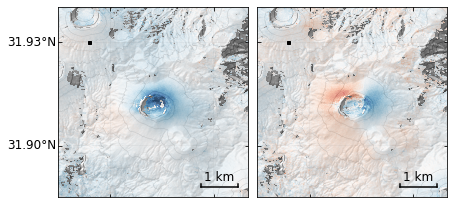

In [44]:
# view.py options
dem_file  = os.path.expanduser('~/insarlab/Kirishima/DEM/Shinmoe10m.dem.wgs84')
opt = ' --sub-lon 130.855 130.91 --sub-lat 31.885 31.94 '
opt += '--dem {} --contour-step 100 --contour-smooth 0.0 '.format(dem_file)
opt += ' -c RdBu_r -v -5 5 -u cm '
opt += ' --notitle --fontsize 12 --ref-size 3 --lalo-step 0.03 --nocbar '
opt += ' --scalebar 0.2 0.85 0.05 --scalebar-pad 0.05 --alpha 0.7 '
#opt += ' --ref-yx {} {} '.format(atr['REF_Y'], atr['REF_X']) #use the same reference point as displacement time-seris
opt += ' --noverbose '

## plot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[6, 3])

# vertical
cmd = 'view.py {f} --lalo-loc 1 0 0 0 {o}'.format(f=up_file, o=opt)
dataUp, atr, inps = view.prep_slice(cmd)
axs[0], inps, im, cbar = view.plot_slice(axs[0], dataUp, atr, inps)

# horizontal
cmd = 'view.py {f} --lalo-loc 0 0 0 0 {o} '.format(f=hz_file, o=opt)
dataHz, atr, inps = view.prep_slice(cmd)
axs[1], inps, im, cbar = view.plot_slice(axs[1], dataHz, atr, inps)

fig.subplots_adjust(wspace=0.05, left=0.05, right=0.95, top=0.95, bottom=0.05)

# output
out_file = os.path.abspath('dis_map_horz_vert.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

save figure to file /Users/yunjunz/Documents/Paper/2019_Kirishima/figs_src/obs_ALOS1/dis_map_cbar.png


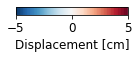

In [52]:
# colorbar
fig, cax = plt.subplots(nrows=1, ncols=1, figsize=[2, 0.15])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-5, 0, 5])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Displacement [cm]', fontsize=font_size)

# output
out_file = os.path.abspath('dis_map_cbar.png')
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to file', out_file)
plt.show()

### Preliminary analysis of source geometry based on the ratio of max horz / vert displacement

In [74]:
max_west_dis = -np.nanmin(dataHz)
max_east_dis = np.nanmax(dataHz)
max_vert_dis = np.nanmax(np.abs(dataUp))
print('max vert displacement: {:.2f} cm'.format(max_vert_dis))
print('max east displacement: {:.2f} cm; horz/vert ratio: {:.2f}'.format(max_east_dis, max_east_dis/max_vert_dis))
print('max west displacement: {:.2f} cm; horz/vert ratio: {:.2f}'.format(max_west_dis, max_west_dis/max_vert_dis))

max vert displacement: 6.50 cm
max east displacement: 3.25 cm; horz/vert ratio: 0.50
max west displacement: 4.65 cm; horz/vert ratio: 0.72


Typical ratio of max horz/vert displacement (Fig. 4 and 6 in Fialko et al., 2001):
+ Sills: < 0.3
+ Spherical sources: ~0.4

Thus, we model this displacement as **Prolate Spheroid** (Yang, 1988) or **Compound Dislocation Models** (Nikkhoo, 2016).